# Install packages

In [2]:
!python -m pip install pyyaml
import sys, os, distutils.core
!pip install torch
# Detectron 2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install torchvision
!pip install opencv-python


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.0/865.0 MB 95.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 127.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 162.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 137.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 211.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 104.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 148.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 246.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 135.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 159.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/usr/bin/sh: 1: nvcc: not found
torch:  2.7 ; cuda:  cu126
detectron2: 0.6


In [4]:
# Other packages

# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, random
import pandas as pd

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

import os
import cv2
from detectron2.data import DatasetCatalog, MetadataCatalog
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import convert_to_coco_json
import shutil
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Import images from GitHub

In [6]:
from getpass import getpass
import subprocess

# Get GitHub token
token = getpass("Enter your GitHub token: ")

# Define repository URL
repo_url = f"https://{token}@github.com/casperbak1/Dataprojekt.git"

# Clone the repository if it doesn't exist (latest version)
subprocess.run(["git", "clone", "--branch", "main", "--depth", "1", repo_url])

repo_path = "Dataprojekt"
if os.path.exists(repo_path):  # Check if the repository already exists
    subprocess.run(["git", "sparse-checkout", "init", "--cone"], cwd=repo_path) # Initialize sparse checkout
    subprocess.run(["git", "sparse-checkout", "set", "Data/Clean Data/Overbite Data"], cwd=repo_path) # Set sparse checkout to only include the "Overbite Data" folder

print("Repository cloned with only the 'Overbite Data' folder.")

Enter your GitHub token:  ········


Repository cloned with only the 'Overbite Data' folder.


# Initialise the training data

In [ ]:
######################## DELETE #############################


from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_name = "Overbite_Data"

# Unregister dataset if already registered
if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)
    MetadataCatalog.remove(dataset_name)
    print(f"Unregistered dataset: {dataset_name}")

In [29]:
# Load the annotations from the CSV file
ANNOTATIONS_FILE = "Dataprojekt/Data/Clean Data/Overbite Data/Updated_Labels.csv"
annotations_df = pd.read_csv(ANNOTATIONS_FILE)

# Define the path to the dataset
DATASET_PATH = "Dataprojekt/Data/Clean Data/Overbite Data/Annotated Data Pairs"

# Function to load the dataset 
# and convert it to the Detectron2 format
def my_dataset_function():
    dataset_dicts = []

    grouped_annotations = annotations_df.groupby("Filename") # Group by filename

    # Iterate through the images in the dataset directory
    # and create a record for each image
    for idx, filename in enumerate(os.listdir(DATASET_PATH)): 
        if filename.endswith((".jpg", ".png", ".jpeg")):
            record = {}
            file_path = os.path.join(DATASET_PATH, filename)

            # Load image to get dimensions
            image = cv2.imread(file_path)
            height, width = image.shape[:2]

            # Convert to grayscale to detect non-black pixels
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Find all non-black pixels
            coords = cv2.findNonZero(gray)  # shape: (N, 1, 2) with [x, y] values
            if coords is not None:
                x_vals = coords[:, 0, 0]
                y_vals = coords[:, 0, 1]

                x_min, x_max = x_vals.min(), x_vals.max()
                y_min, y_max = y_vals.min(), y_vals.max()

                bbox = [int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)]
            else:
                # Fallback in case the image is completely black
                bbox = [0, 0, width, height]

            # Set record metadata 
            record["file_name"] = file_path
            record["image_id"] = idx
            record["height"] = height
            record["width"] = width
            record["annotations"] = []

            # Add bounding box and keypoints annotations
            if filename in grouped_annotations.groups:
                keypoints_list = []
                for _, row in grouped_annotations.get_group(filename).iterrows():
                    x, y = row["X"], row["Y"]
                    keypoints_list.extend([x, y, 2])

                annotation = {
                    "bbox": bbox,
                    "bbox_mode": BoxMode.XYWH_ABS, 
                    "category_id": 0,   # Assuming a single class
                    "keypoints": keypoints_list, # List of keypoints
                    "num_keypoints": len(keypoints_list) // 3 # Number of keypoints
                }
                record["annotations"].append(annotation)

            dataset_dicts.append(record)

    return dataset_dicts

# Register the dataset  
DatasetCatalog.register("Overbite_Data", my_dataset_function)
MetadataCatalog.get("Overbite_Data").set(
    thing_classes=["object"],  # Modify for actual class names 
    keypoint_names=["keypoint"],  # Name of keypoints 
    keypoint_flip_map=[]  # Add keypoint flip pairs if needed
)

# Test if it works
dataset_dicts = DatasetCatalog.get("Overbite_Data")
print(f"Loaded {len(dataset_dicts)} images with keypoints.")

Loaded 1585 images with keypoints.


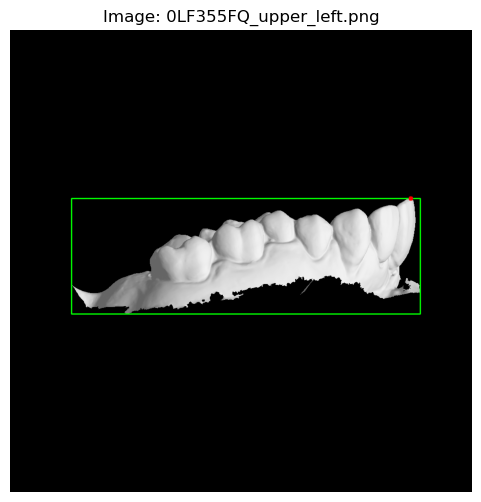

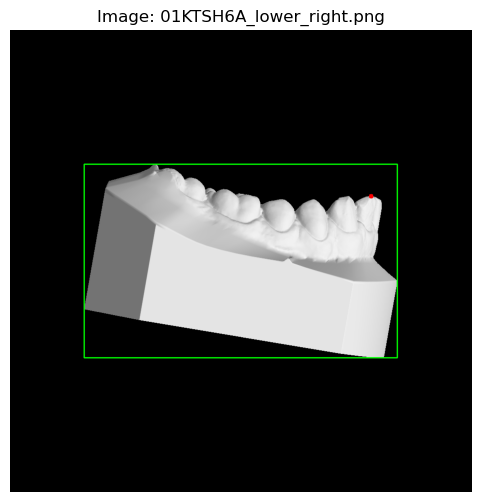

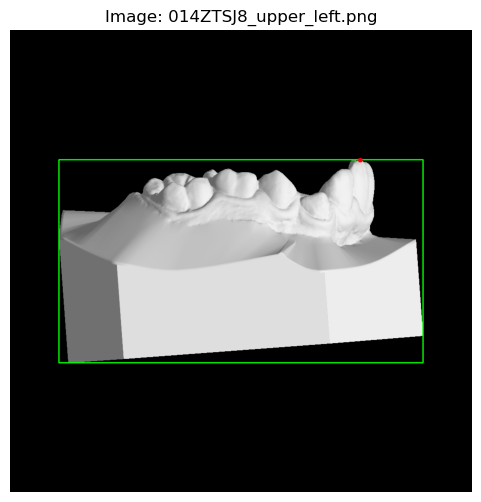

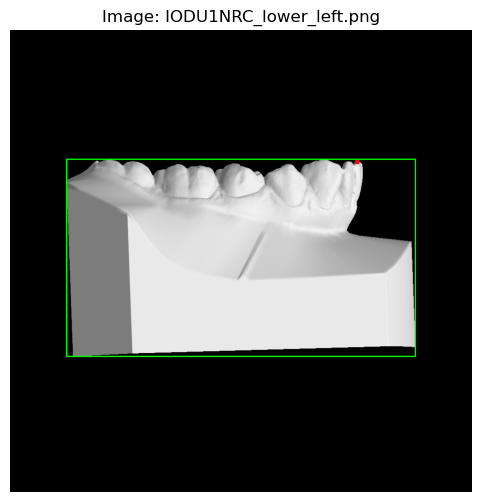

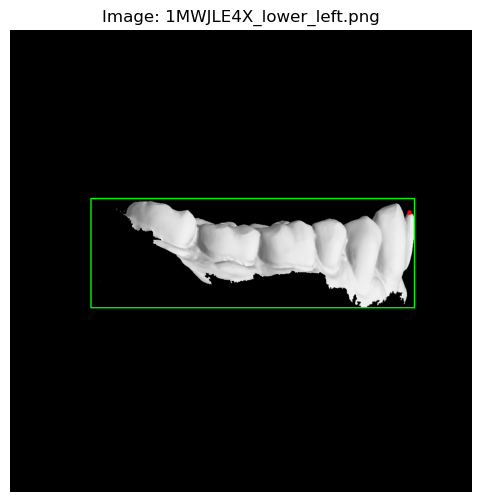

In [30]:
################# VISUALIZE ####################

import cv2
import random
import matplotlib.pyplot as plt

# Load dataset dicts
dataset_dicts = my_dataset_function()

# Pick 3–5 random samples
sampled = random.sample(dataset_dicts, min(5, len(dataset_dicts)))

for d in sampled:
    img = cv2.imread(d["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for matplotlib display

    for anno in d["annotations"]:
        # Draw bbox (green rectangle)
        x, y, w, h = map(int, anno["bbox"])
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Draw keypoint (red dot)
        kp_x, kp_y = int(anno["keypoints"][0]), int(anno["keypoints"][1])
        cv2.circle(img, (kp_x, kp_y), 5, (255, 0, 0), -1)  

    # Show with matplotlib
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Image: {os.path.basename(d['file_name'])}")
    plt.axis("off")
    plt.show()


# Initialise Validation Data

In [31]:
# Function for the validation dataset
def my_validation_function():
    dataset_dicts = []
    DATASET_PATH = "Dataprojekt/Data/Clean Data/Overbite Data/Annotated Verication data"

    grouped_annotations = annotations_df.groupby("Filename")

    # Iterate through the images in the dataset directory
    for idx, filename in enumerate(os.listdir(DATASET_PATH)):
        if filename.endswith((".jpg", ".png", ".jpeg")):
            record = {}
            file_path = os.path.join(DATASET_PATH, filename)
            image = cv2.imread(file_path)
            height, width = image.shape[:2]

            # Detect non-black bounding box 
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            coords = cv2.findNonZero(gray)

            # Find all non-black pixels
            if coords is not None:
                x_vals = coords[:, 0, 0]
                y_vals = coords[:, 0, 1]
                x_min, x_max = x_vals.min(), x_vals.max()
                y_min, y_max = y_vals.min(), y_vals.max()
                bbox = [int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)]
            else:
                bbox = [0, 0, width, height]  # fallback if the image is completely black

            record["file_name"] = file_path
            record["image_id"] = idx
            record["height"] = height
            record["width"] = width
            record["annotations"] = []

            if filename in grouped_annotations.groups:
                keypoints_list = []

                for _, row in grouped_annotations.get_group(filename).iterrows():
                    x, y = row["X"], row["Y"]
                    keypoints_list.extend([x, y, 2])

                annotation = {
                    "bbox": bbox, # bounding box
                    "bbox_mode": BoxMode.XYWH_ABS, # absolute coordinates
                    "category_id": 0, # single class
                    "keypoints": keypoints_list, # list of keypoints
                    "num_keypoints": len(keypoints_list) // 3  # number of keypoints
                }

                record["annotations"].append(annotation)

            dataset_dicts.append(record)

    return dataset_dicts

# Registrér valideringsdatasæt
DatasetCatalog.register("Overbite_Validation", my_validation_function)
MetadataCatalog.get("Overbite_Validation").set(
    thing_classes=["object"], # Modify for actual class names
    keypoint_names=["keypoint"], # Name of keypoints
    keypoint_flip_map=[] # Add keypoint flip pairs if needed
)

namespace(name='Overbite_Validation',
          thing_classes=['object'],
          keypoint_names=['keypoint'],
          keypoint_flip_map=[])

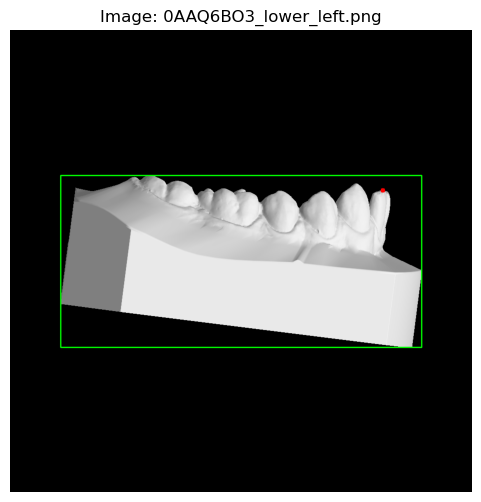

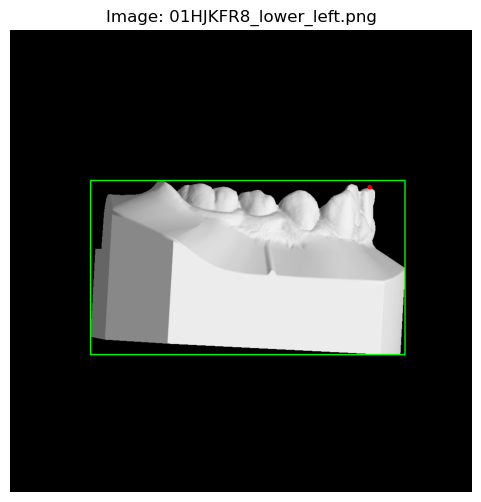

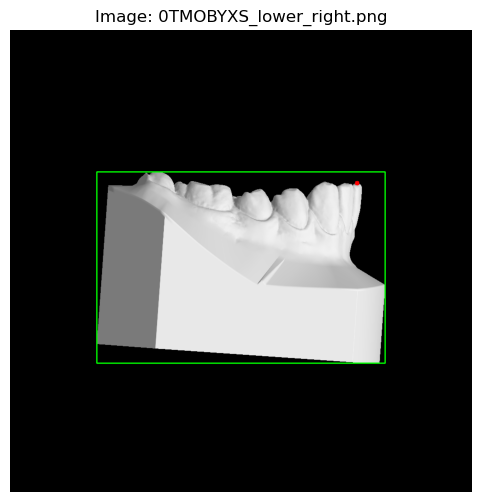

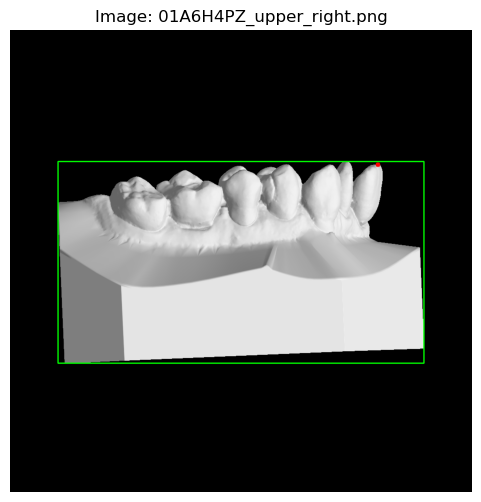

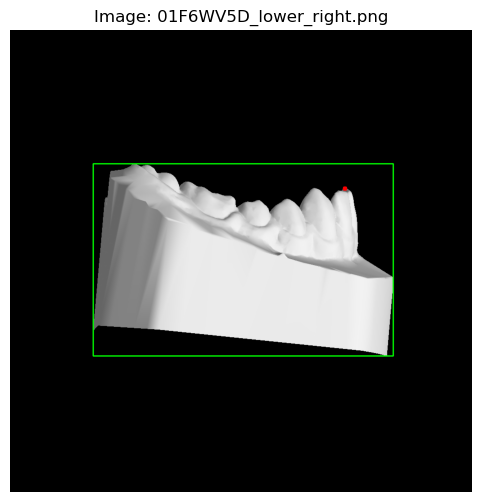

In [32]:
################# VISUALIZE ####################

import cv2
import random
import matplotlib.pyplot as plt

# Load dataset dicts
dataset_dicts = my_validation_function()

# Pick 3–5 random samples
sampled = random.sample(dataset_dicts, min(5, len(dataset_dicts)))

for d in sampled:
    img = cv2.imread(d["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for matplotlib display

    for anno in d["annotations"]:
        # Draw bbox (green rectangle)
        x, y, w, h = map(int, anno["bbox"])
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Draw keypoint (red dot)
        kp_x, kp_y = int(anno["keypoints"][0]), int(anno["keypoints"][1])
        cv2.circle(img, (kp_x, kp_y), 5, (255, 0, 0), -1) # Red dot

    # Show with matplotlib
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Image: {os.path.basename(d['file_name'])}")
    plt.axis("off")
    plt.show()


# Train the model

In [33]:
# Import necessary libraries
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import convert_to_coco_json

# Create the configuration 
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))  # Load Keypoint-RCNN config (ResNet-101 backbone)
cfg.DATASETS.TRAIN = ("Overbite_Data",)  # Training dataset 
cfg.DATASETS.TEST = ("Overbite_Validation",)  # Validation dataset
cfg.DATALOADER.NUM_WORKERS = 16 # Number of workers for data loading 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")  # Pretrained weights 
cfg.SOLVER.IMS_PER_BATCH = 64  # Batch size (Number of images per batch) (Larger batches should ideally provide better training, but we have limited GPU in 'Colab')
cfg.SOLVER.BASE_LR = 0.00025  # Learning rate 
cfg.SOLVER.MAX_ITER = 100000  # Total number of iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # Number of proposals to be considered per image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Number of classes (1 for our dataset)
cfg.MODEL.KEYPOINT_ON = True  # Enable keypoint detection
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 1  # Number of keypoints (1 for our dataset)


cfg.TEST.KEYPOINT_OKS_SIGMAS = [0.1] # Set OKS sigma for 1 keypoint (Default is 17 for COCO)

# Set evaluation period, validation every 500 iterations
cfg.TEST.EVAL_PERIOD = 500

# Set checkpoint saving period 
cfg.SOLVER.CHECKPOINT_PERIOD = 1000  # Save every 1000 iterations

# Output directory for model checkpoints and logs
cfg.OUTPUT_DIR = "./output/Overbite_Model"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Convert the validation set to COCO JSON format
coco_annotation_path = os.path.join(cfg.OUTPUT_DIR, "Overbite_Validation_coco_format.json")
convert_to_coco_json("Overbite_Validation", coco_annotation_path)
print(f"Validation set converted to COCO format: {coco_annotation_path}")

# Create a custom trainer class to include evaluation
class TrainerWithEval(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR)

# Create a trainer instance with evaluation
trainer = TrainerWithEval(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Evaluate the model on the validation set a last time
val_loader = build_detection_test_loader(cfg, "Overbite_Validation")
inference_on_dataset(trainer.model, val_loader, COCOEvaluator("Overbite_Validation", cfg, False, output_dir=cfg.OUTPUT_DIR))

print("Training and validation completed!")

[05/14 18:19:46 d2.data.datasets.coco]: Converting annotations of dataset 'Overbite_Validation' to COCO format ...)
[05/14 18:19:47 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/14 18:19:47 d2.data.datasets.coco]: Conversion finished, #images: 100, #annotations: 100
[05/14 18:19:47 d2.data.datasets.coco]: Caching COCO format annotations at './output/Overbite_Model/Overbite_Validation_coco_format.json' ...
Validation set converted to COCO format: ./output/Overbite_Model/Overbite_Validation_coco_format.json
[05/14 18:19:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1

Skip loading parameter 'roi_heads.keypoint_head.score_lowres.weight' to the model due to incompatible shapes: (512, 17, 4, 4) in the checkpoint but (512, 1, 4, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.bias' to the model due to incompatible shapes: (17,) in the checkpoint but (1,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.keypoint_head.score_lowres.{bias, weight}


[05/14 18:20:04 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.12/site-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/opt/conda/lib/python3.12/site-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/opt/conda/lib/python3.12/site-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. P

[05/14 18:20:26 d2.utils.events]:  eta: 1 day, 7:22:29  iter: 19  total_loss: 9.474  loss_cls: 0.9426  loss_box_reg: 0.3191  loss_keypoint: 8.124  loss_rpn_cls: 0.07401  loss_rpn_loc: 0.01245    time: 1.1271  last_time: 1.1407  data_time: 0.1496  last_data_time: 0.1501   lr: 4.9953e-06  max_mem: 53911M
[05/14 18:20:50 d2.utils.events]:  eta: 1 day, 7:44:05  iter: 39  total_loss: 9.208  loss_cls: 0.7196  loss_box_reg: 0.3162  loss_keypoint: 8.082  loss_rpn_cls: 0.05613  loss_rpn_loc: 0.01224    time: 1.1528  last_time: 1.1779  data_time: 0.1755  last_data_time: 0.1548   lr: 9.9902e-06  max_mem: 53912M
[05/14 18:21:13 d2.utils.events]:  eta: 1 day, 8:03:01  iter: 59  total_loss: 8.646  loss_cls: 0.3132  loss_box_reg: 0.2809  loss_keypoint: 7.993  loss_rpn_cls: 0.02868  loss_rpn_loc: 0.01017    time: 1.1573  last_time: 1.1364  data_time: 0.1664  last_data_time: 0.1342   lr: 1.4985e-05  max_mem: 53912M
[05/14 18:21:37 d2.utils.events]:  eta: 1 day, 8:05:11  iter: 79  total_loss: 8.233  los

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fed232351c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fed232351c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.12/site-packages/torch/utils/data/dataloader.py", l

[05/14 21:14:23 d2.utils.events]:  eta: 1 day, 6:08:53  iter: 8699  total_loss: 0.3829  loss_cls: 0.009262  loss_box_reg: 0.005916  loss_keypoint: 0.3658  loss_rpn_cls: 4.027e-05  loss_rpn_loc: 0.001358    time: 1.1943  last_time: 1.2159  data_time: 0.1944  last_data_time: 0.1926   lr: 0.00025  max_mem: 53912M
[05/14 21:14:47 d2.utils.events]:  eta: 1 day, 6:08:33  iter: 8719  total_loss: 0.3833  loss_cls: 0.009707  loss_box_reg: 0.006151  loss_keypoint: 0.3645  loss_rpn_cls: 4.474e-05  loss_rpn_loc: 0.001263    time: 1.1943  last_time: 1.1603  data_time: 0.1793  last_data_time: 0.1459   lr: 0.00025  max_mem: 53912M
[05/14 21:15:11 d2.utils.events]:  eta: 1 day, 6:08:40  iter: 8739  total_loss: 0.3921  loss_cls: 0.009014  loss_box_reg: 0.00578  loss_keypoint: 0.376  loss_rpn_cls: 5.699e-05  loss_rpn_loc: 0.001255    time: 1.1943  last_time: 1.1654  data_time: 0.1803  last_data_time: 0.1677   lr: 0.00025  max_mem: 53912M
[05/14 21:15:35 d2.utils.events]:  eta: 1 day, 6:08:04  iter: 8759

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fed232351c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fed232351c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()

  File "/opt/conda/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
  File "/opt/conda/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():    
if w.is_alive(): 
           ^ ^ ^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fed232351c0>^^

^Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/multiprocessing/proces

[05/14 21:18:46 d2.utils.events]:  eta: 1 day, 6:04:40  iter: 8919  total_loss: 0.3848  loss_cls: 0.007899  loss_box_reg: 0.005951  loss_keypoint: 0.3698  loss_rpn_cls: 7.683e-05  loss_rpn_loc: 0.001266    time: 1.1943  last_time: 1.2048  data_time: 0.1763  last_data_time: 0.1823   lr: 0.00025  max_mem: 53912M
[05/14 21:19:10 d2.utils.events]:  eta: 1 day, 6:04:16  iter: 8939  total_loss: 0.393  loss_cls: 0.008713  loss_box_reg: 0.005913  loss_keypoint: 0.3767  loss_rpn_cls: 4.5e-05  loss_rpn_loc: 0.001256    time: 1.1943  last_time: 1.1665  data_time: 0.1682  last_data_time: 0.1555   lr: 0.00025  max_mem: 53912M
[05/14 21:19:34 d2.utils.events]:  eta: 1 day, 6:04:19  iter: 8959  total_loss: 0.3738  loss_cls: 0.008751  loss_box_reg: 0.005761  loss_keypoint: 0.3566  loss_rpn_cls: 7.892e-05  loss_rpn_loc: 0.001343    time: 1.1943  last_time: 1.3469  data_time: 0.1861  last_data_time: 0.3376   lr: 0.00025  max_mem: 53912M
[05/14 21:19:58 d2.utils.events]:  eta: 1 day, 6:04:26  iter: 8979 

KeyboardInterrupt: 